In [1]:
import pandas as pd
import numpy as np

file_readm = "/home/idies/workspace/Storage/ehan20/persistent/as.180.369/contrib/ElvisHan2022/Copy of FY 2019 IPPS Proposed Rule Readmissions Supplemental Data File.xlsx"
sheet_name = "NPRM FY 2019"

# --- Step 1 : Read first few rows (no header) to detect where "Hospital CCN" appears ---
preview = pd.read_excel(file_readm, sheet_name=sheet_name, header=None, nrows=10)

header_row = None
for i, row in preview.iterrows():
    if row.astype(str).str.contains("Hospital CCN", case=False, na=False).any():
        header_row = i
        break

if header_row is None:
    header_row = 0  # fallback if pattern not found

print(f"Detected header row = {header_row}")

# --- Step 2 : Read the sheet again using the detected header row ---
df = pd.read_excel(file_readm, sheet_name=sheet_name, header=header_row)

# --- Step 3 : Clean column names (strip spaces, collapse multiple spaces) ---
df.columns = (
    df.columns.astype(str)
    .str.replace("\xa0", " ", regex=False)     # remove non-breaking spaces
    .str.replace(r"\s+", " ", regex=True)      # collapse extra spaces
    .str.strip()
)

print("✅ Loaded HRRP sheet successfully!")
print("Shape:", df.shape)
print("First 10 columns:")
print(df.columns.tolist()[:10])


Detected header row = 1
✅ Loaded HRRP sheet successfully!
Shape: (3167, 35)
First 10 columns:
['Hospital CCN', 'FY 2019 Proposed Proxy Payment Adjustment Factor', 'Dual proportion', 'Peer group assignment', 'Neutrality modifier', 'Number of eligible discharges for AMI', 'ERR for AMI', 'Peer group median ERR for AMI', 'Penalty indicator for AMI', 'DRG payment ratio for AMI']


In [2]:
# ==============================================================
# STEP 4.  BUILD df_eda (EXPLORATORY DATASET)
# --------------------------------------------------------------
# We isolate the columns required for our descriptive and regression
# analyses.  Columns not in this list (e.g., documentation sheets)
# are ignored to reduce clutter.
# ==============================================================

cols_keep = [
    "Hospital CCN",
    "FY 2019 Proposed Proxy Payment Adjustment Factor",
    "Dual proportion",
    "Peer group assignment",
    "Neutrality modifier",

    # Condition-specific variables
    "Number of eligible discharges for AMI", "ERR for AMI", "Peer group median ERR for AMI", "Penalty indicator for AMI", "DRG payment ratio for AMI",
    "Number of eligible discharges for COPD", "ERR for COPD", "Peer group median ERR for COPD", "Penalty indicator for COPD", "DRG payment ratio for COPD",
    "Number of eligible discharges for HF", "ERR for HF", "Peer group median ERR for HF", "Penalty indicator for HF", "DRG payment ratio for HF",
    "Number of eligible discharges for Pneumonia", "ERR for Pneumonia", "Peer group median ERR for Pneumonia", "Penalty indicator for Pneumonia", "DRG payment ratio for Pneumonia",
    "Number of eligible discharges for CABG", "ERR for CABG", "Peer group median ERR for CABG", "Penalty indicator for CABG", "DRG payment ratio for CABG",
    "Number of eligible discharges for THA/TKA", "ERR for THA/TKA", "Peer group median ERR for THA/TKA", "Penalty indicator for THA/TKA", "DRG payment ratio for THA/TKA",
]

# Only keep columns that exist (avoids KeyErrors)
cols_present = [c for c in cols_keep if c in df.columns]
df_eda = df[cols_present].copy()

# Rename a few long variables for easier referencing later
df_eda = df_eda.rename(columns={
    "FY 2019 Proposed Proxy Payment Adjustment Factor": "A_h",  # Payment-Adjustment factor
    "Dual proportion": "DualShare",
    "Peer group assignment": "PeerGroup",
})

print("✅ Variables selected for EDA:", len(df_eda.columns))


✅ Variables selected for EDA: 35


In [3]:
# ==============================================================
# STEP 5.  CLEAN VALUES AND CREATE PENALTY FLAGS
# --------------------------------------------------------------
# 1. Replace text placeholders (e.g., "NQ") with NaN.
# 2. Coerce numeric columns.
# 3. Normalize Y/N penalty indicators.
# 4. Create binary flags:
#      • Penalized_any → 1 if A_h < 1
#      • Pen_AMI ... Pen_THA_TKA → 1 if CMS lists Y for that condition
# ==============================================================

df_eda = df_eda.replace("NQ", np.nan)

# Normalize penalty indicators and numeric variables
for c in df_eda.columns:
    if c.startswith("Penalty indicator"):
        df_eda[c] = df_eda[c].astype(str).str.upper().str.strip()
    else:
        df_eda[c] = pd.to_numeric(df_eda[c], errors="ignore")

for c in ["A_h", "DualShare", "Neutrality modifier"]:
    if c in df_eda.columns:
        df_eda[c] = pd.to_numeric(df_eda[c], errors="coerce")

# Overall penalty status
df_eda["Penalized_any"] = np.where(df_eda["A_h"] < 1, 1, 0)

# Condition-specific penalty flags
cond_map = {
    "AMI": "Penalty indicator for AMI",
    "COPD": "Penalty indicator for COPD",
    "HF": "Penalty indicator for HF",
    "Pneumonia": "Penalty indicator for Pneumonia",
    "CABG": "Penalty indicator for CABG",
    "THA_TKA": "Penalty indicator for THA/TKA",
}
for k, col in cond_map.items():
    if col in df_eda.columns:
        df_eda[f"Pen_{k}"] = df_eda[col].map({"Y": 1, "N": 0}).astype("Int64")

print("✅ Data cleaned. Preview:")
display(df_eda.head(3))


✅ Data cleaned. Preview:


/tmp/ipykernel_156/3316998736.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_eda = df_eda.replace("NQ", np.nan)
/tmp/ipykernel_156/3316998736.py:19: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df_eda[c] = pd.to_numeric(df_eda[c], errors="ignore")
/tmp/ipykernel_156/3316998736.py:19: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df_eda[c] = pd.to_numeric(df_eda[c], errors="ignore")
/tmp/ipykernel_156/3316998736.py:19: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric withou

,Hospital CCN,A_h,DualShare,PeerGroup,Neutrality modifier,Number of eligible discharges for AMI,ERR for AMI,Peer group median ERR for AMI,Penalty indicator for AMI,DRG payment ratio for AMI,...,Peer group median ERR for THA/TKA,Penalty indicator for THA/TKA,DRG payment ratio for THA/TKA,Penalized_any,Pen_AMI,Pen_COPD,Pen_HF,Pen_Pneumonia,Pen_CABG,Pen_THA_TKA
0,010001,0.9941,0.165328,2.0,0.948106,810.0,0.987485,0.996365,N,0.045309,...,0.990957,Y,0.017070,1,0,0,0,1,1,1
1,010005,0.9860,0.162036,2.0,0.948106,53.0,0.969510,0.996365,N,0.006251,...,0.990957,Y,0.036328,1,0,0,1,0,0,1
2,010006,0.9864,0.116248,1.0,0.948106,395.0,1.041671,0.995627,Y,0.034242,...,0.987525,Y,0.029990,1,1,1,1,1,1,1


In [4]:
# ==============================================================
# STEP 6.  DEFINE EASY SUMMARY FUNCTION
# --------------------------------------------------------------
# This helper produces simple descriptive statistics for any
# numeric column: count, mean, SD, min, quartiles, and max.
# ==============================================================

def easy_summary(series, name):
    s = pd.to_numeric(series, errors="coerce")
    return pd.Series({
        "count": int(s.notna().sum()),
        "missing": int(s.isna().sum()),
        "mean": s.mean(),
        "std": s.std(),
        "min": s.min(),
        "p25": s.quantile(0.25),
        "median": s.median(),
        "p75": s.quantile(0.75),
        "max": s.max(),
    }, name=name)


In [5]:
# ==============================================================
# STEP 8.  SUMMARIZE EXCESS READMISSION RATIOS (ERR)
# --------------------------------------------------------------
# For each monitored condition, compute central tendency and spread.
# These variables capture hospital performance under HRRP.
# ==============================================================

err_cols = [c for c in df_eda.columns if str(c).startswith("ERR for ")]
err_summary_df = pd.DataFrame([easy_summary(df_eda[c], c) for c in err_cols])

print("=== Excess Readmission Ratios (ERR) by Condition ===")
display(err_summary_df.round(4))


=== Excess Readmission Ratios (ERR) by Condition ===


,count,missing,mean,std,min,p25,median,p75,max
ERR for AMI,2928.0,239.0,1.0010,0.0526,0.7518,0.9755,0.9975,1.0253,1.2380
ERR for COPD,3041.0,126.0,1.0012,0.0603,0.8143,0.9630,0.9969,1.0363,1.3544
ERR for HF,3025.0,142.0,1.0016,0.0754,0.7170,0.9539,0.9990,1.0459,1.4113
ERR for Pneumonia,3052.0,115.0,1.0018,0.0813,0.7635,0.9479,0.9964,1.0512,1.3615
ERR for CABG,1154.0,2013.0,1.0038,0.0945,0.7095,0.9441,0.9972,1.0573,1.5085
ERR for THA/TKA,2808.0,359.0,1.0077,0.1318,0.5612,0.9282,0.9942,1.0736,1.7293


In [6]:
# ==============================================================
# STEP 10.  PENALTY INCIDENCE
# --------------------------------------------------------------
# Measures how many hospitals were penalized overall (A_h<1)
# and for each condition (Y/N in CMS indicator fields).
# ==============================================================

total_hosp = len(df_eda)
rows = []

# Overall
if "Penalized_any" in df_eda.columns:
    n_any = int(df_eda["Penalized_any"].sum())
    pct_any = round(100 * n_any / total_hosp, 1)
    rows.append(pd.Series({
        "Hospitals penalized": n_any,
        "Share penalized (%)": pct_any,
        "N (hospitals)": total_hosp
    }, name="Overall (A_h < 1)"))

# Condition-specific
for k in ["AMI","COPD","HF","Pneumonia","CABG","THA_TKA"]:
    col = f"Pen_{k}"
    if col in df_eda.columns:
        n = int(df_eda[col].sum(skipna=True))
        denom = int(df_eda[col].notna().sum())
        pct = round(100 * n / denom, 1)
        rows.append(pd.Series({
            "Hospitals penalized": n,
            "Share penalized (%)": pct,
            "N (hospitals)": denom
        }, name=k))

penalty_table = pd.DataFrame(rows)
print("=== Penalty Incidence (Overall and by Condition) ===")
display(penalty_table)


=== Penalty Incidence (Overall and by Condition) ===


,Hospitals penalized,Share penalized (%),N (hospitals)
Overall (A_h < 1),2610.0,82.4,3167.0
AMI,1088.0,34.4,3166.0
COPD,1413.0,44.6,3166.0
HF,1419.0,44.8,3166.0
Pneumonia,1452.0,45.9,3166.0
CABG,502.0,15.9,3166.0
THA_TKA,1212.0,38.3,3166.0


In [7]:
# ==============================================================
# STEP 11.  COMPARE PENALIZED VS NON-PENALIZED HOSPITALS
# --------------------------------------------------------------
# This section explores whether penalized hospitals systematically
# differ in socioeconomic composition (DualShare) or performance (ERR).
# ==============================================================

# Label each hospital
df_eda["Penalized_label"] = np.where(df_eda["A_h"] < 1, "Penalized", "Not Penalized")

# Variables to compare
compare_vars = ["DualShare", "Neutrality modifier", "PeerGroup"] + [c for c in df_eda.columns if c.startswith("ERR for ")]

# Group means and differences
group_means = df_eda.groupby("Penalized_label")[compare_vars].mean(numeric_only=True).T
group_means.columns = [f"Mean ({c})" for c in group_means.columns]
if {"Mean (Penalized)", "Mean (Not Penalized)"} <= set(group_means.columns):
    group_means["Difference"] = group_means["Mean (Penalized)"] - group_means["Mean (Not Penalized)"]

print("=== Mean Comparison: Penalized vs Not Penalized ===")
display(group_means.round(4))


=== Mean Comparison: Penalized vs Not Penalized ===


,Mean (Not Penalized),Mean (Penalized),Difference
DualShare,0.2318,0.2453,0.0135
Neutrality modifier,0.9481,0.9481,0.0000
PeerGroup,2.8058,3.0406,0.2349
ERR for AMI,0.9678,1.0059,0.0381
ERR for COPD,0.9643,1.0077,0.0434
ERR for HF,0.9502,1.0104,0.0602
ERR for Pneumonia,0.9445,1.0121,0.0676
ERR for CABG,0.9193,1.0121,0.0928
ERR for THA/TKA,0.9137,1.0235,0.1097


In [8]:
# ==============================================================
# Q1. Do hospitals serving poorer populations have worse performance?
# --------------------------------------------------------------
# Model: ERR_{h,c} = α_c + β * DualShare_h + ε
# --------------------------------------------------------------
# β > 0 → hospitals with higher DualShare have higher ERRs
#          (worse readmission performance)
# ==============================================================

import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# 1️⃣ Define the conditions you’ll analyze
conditions = ["AMI", "COPD", "HF", "Pneumonia", "CABG", "THA_TKA"]

# 2️⃣ Run regressions for each condition: ERR ~ DualShare
results_q1 = []
for c in conditions:
    err_col = f"ERR for {c}"
    if err_col in df_eda.columns:
        model = smf.ols(f"Q('{err_col}') ~ DualShare", data=df_eda).fit()
        beta = model.params.get("DualShare", None)
        se   = model.bse.get("DualShare", None)
        pval = model.pvalues.get("DualShare", None)
        r2   = model.rsquared
        n    = int(model.nobs)
        results_q1.append({
            "Condition": c,
            "Beta (DualShare)": beta,
            "Std. Err.": se,
            "p-value": pval,
            "R²": r2,
            "N": n
        })

# 3️⃣ Display regression summary table
results_q1_df = pd.DataFrame(results_q1)
print("=== Q1 Results: Effect of DualShare on Hospital ERRs ===")
display(results_q1_df.round(4))


=== Q1 Results: Effect of DualShare on Hospital ERRs ===


,Condition,Beta (DualShare),Std. Err.,p-value,R²,N
0,AMI,0.0512,0.0073,0.0000,0.0165,2928
1,COPD,0.0579,0.0079,0.0000,0.0175,3041
2,HF,0.1446,0.0097,0.0000,0.0687,3025
3,Pneumonia,0.1342,0.0103,0.0000,0.0525,3052
4,CABG,0.0483,0.0245,0.0486,0.0034,1154


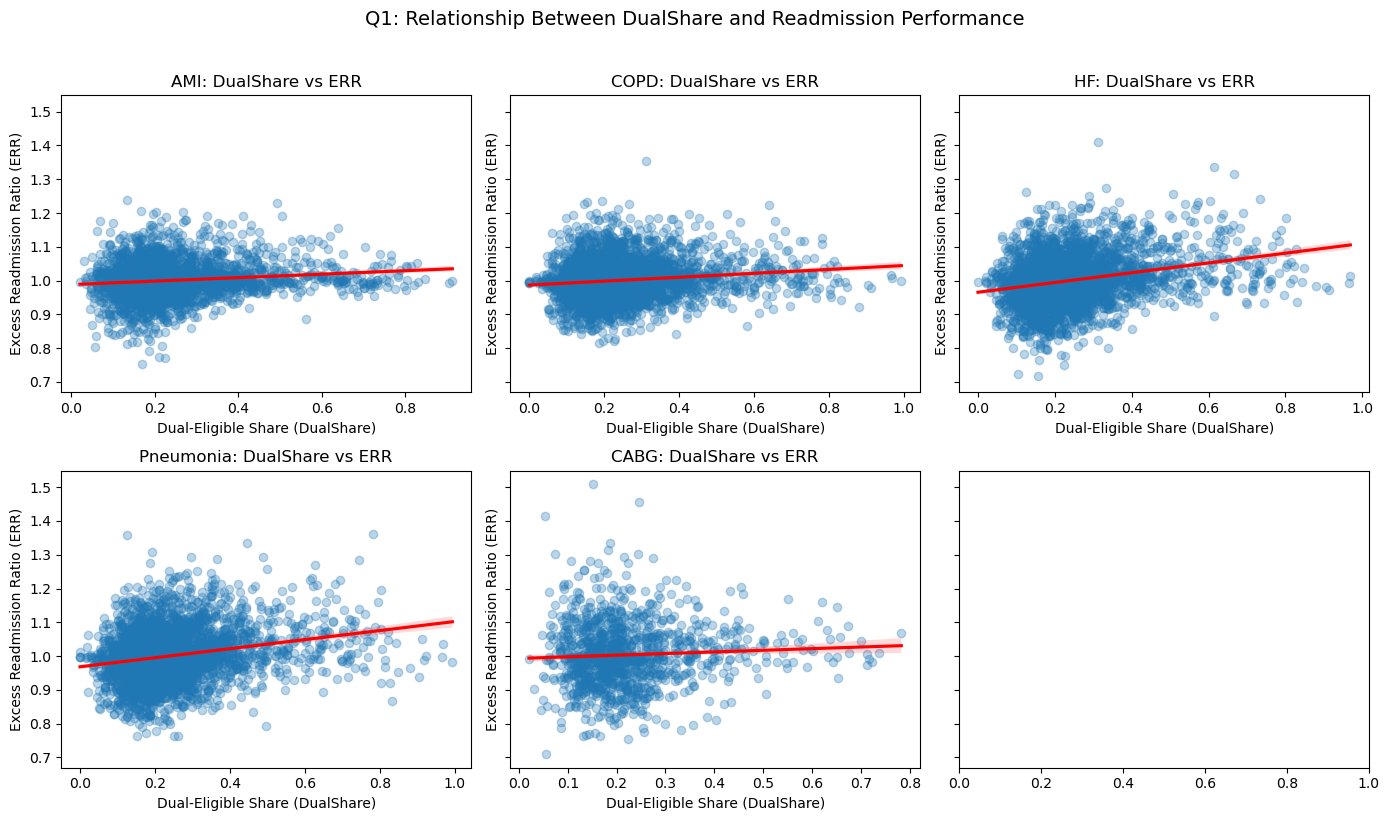

In [9]:
# ==============================================================
# VISUALIZATION: DualShare vs ERR for each condition
# --------------------------------------------------------------
# Scatter plots with fitted regression lines.
# Shows whether hospitals with higher DualShare tend to have higher ERRs.
# ==============================================================

fig, axes = plt.subplots(2, 3, figsize=(14,8), sharey=True)
for ax, cond in zip(axes.flatten(), conditions):
    col = f"ERR for {cond}"
    if col in df_eda.columns:
        sns.regplot(x="DualShare", y=col, data=df_eda,
                    scatter_kws={"alpha":0.3}, line_kws={"color":"red"}, ax=ax)
        ax.set_title(f"{cond}: DualShare vs ERR")
        ax.set_xlabel("Dual-Eligible Share (DualShare)")
        ax.set_ylabel("Excess Readmission Ratio (ERR)")
plt.suptitle("Q1: Relationship Between DualShare and Readmission Performance", y=1.02, fontsize=14)
plt.tight_layout()
plt.show()


In [18]:
# ==============================================================
# Q2. Does peer-group adjustment neutralize socioeconomic disadvantage?
# --------------------------------------------------------------
# Model: (ERR_{h,c} - ERR^{peer}_{c}) = α + β * DualShare_h + ε
# --------------------------------------------------------------
# β > 0 → Hospitals with higher DualShare still perform worse
#          than their peers even after adjustment.
# ==============================================================

import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# 1️⃣ Create a list of conditions
conditions = ["AMI", "COPD", "HF", "Pneumonia", "CABG", "THA_TKA"]

# 2️⃣ Run regressions for ERR_diff_c ~ DualShare
results_q2 = []
for c in conditions:
    var = f"ERR_diff_{c}"
    if var in df_eda.columns:
        model = smf.ols(f"Q('{var}') ~ DualShare", data=df_eda).fit()
        beta = model.params.get("DualShare", None)
        se   = model.bse.get("DualShare", None)
        pval = model.pvalues.get("DualShare", None)
        r2   = model.rsquared
        n    = int(model.nobs)
        results_q2.append({
            "Condition": c,
            "Beta (DualShare)": beta,
            "Std. Err.": se,
            "p-value": pval,
            "R²": r2,
            "N": n
        })

# 3️⃣ Display results table
results_q2_df = pd.DataFrame(results_q2)
print("=== Q2 Results: Effect of DualShare on ERR Deviation from Peer Median ===")
display(results_q2_df.round(4))


=== Q2 Results: Effect of DualShare on ERR Deviation from Peer Median ===


,Condition,Beta (DualShare),Std. Err.,p-value,R²,N
0,AMI,0.0299,0.0073,0.0000,0.0057,2928
1,COPD,0.0147,0.0079,0.0619,0.0011,3041
2,HF,0.0404,0.0097,0.0000,0.0058,3025
3,Pneumonia,0.0274,0.0103,0.0078,0.0023,3052
4,CABG,-0.0176,0.0245,0.4724,0.0004,1154
5,THA_TKA,0.0552,0.0189,0.0036,0.0030,2808


In [12]:
# ==============================================================
# VISUALIZATION: Mean ERR deviation (ERR_diff) by DualShare quartile
# --------------------------------------------------------------
# Bar chart across quartiles of DualShare for each condition.
# ==============================================================

df_eda["DualShare_quartile"] = pd.qcut(df_eda["DualShare"], 4, labels=["Q1 Low","Q2","Q3","Q4 High"])
err_diff_cols = [f"ERR_diff_{c}" for c in conditions]
df_plot = df_eda.groupby("DualShare_quartile")[err_diff_cols].mean().reset_index()

df_plot_melt = df_plot.melt(id_vars="DualShare_quartile", var_name="Condition", value_name="Mean ERR Deviation")
df_plot_melt["Condition"] = df_plot_melt["Condition"].str.replace("ERR_diff_", "")

plt.figure(figsize=(10,6))
sns.barplot(x="DualShare_quartile", y="Mean ERR Deviation", hue="Condition", data=df_plot_melt)
plt.title("Q2: Mean Deviation from Peer Median ERR by DualShare Quartile")
plt.xlabel("DualShare Quartile (Low → High)")
plt.ylabel("Average (ERR − Peer Median)")
plt.legend(title="Condition", bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()


/tmp/ipykernel_156/2281296010.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_plot = df_eda.groupby("DualShare_quartile")[err_diff_cols].mean().reset_index()


KeyError: "Columns not found: 'ERR_diff_Pneumonia', 'ERR_diff_HF', 'ERR_diff_CABG', 'ERR_diff_COPD', 'ERR_diff_THA_TKA', 'ERR_diff_AMI'"

In [13]:
# ==============================================================
# Q3. Are poorer hospitals more exposed to financially important conditions?
# --------------------------------------------------------------
# Model: DRG_ratio_{h,c} = α + β * DualShare_h + ε
# --------------------------------------------------------------
# β > 0 → Hospitals with higher DualShare rely more on that condition's DRG payments,
#          implying higher exposure in the penalty calculation.
# ==============================================================

import statsmodels.formula.api as smf
import pandas as pd

results_q3 = []
for c in conditions:
    var = f"DRG payment ratio for {c}"
    if var in df_eda.columns:
        model = smf.ols(f"Q('{var}') ~ DualShare", data=df_eda).fit()
        beta = model.params.get("DualShare", None)
        se   = model.bse.get("DualShare", None)
        pval = model.pvalues.get("DualShare", None)
        r2   = model.rsquared
        n    = int(model.nobs)
        results_q3.append({
            "Condition": c,
            "Beta (DualShare)": beta,
            "Std. Err.": se,
            "p-value": pval,
            "R²": r2,
            "N": n
        })

results_q3_df = pd.DataFrame(results_q3)
print("=== Q3 Results: Relationship Between DualShare and DRG Payment Ratios ===")
display(results_q3_df.round(4))


=== Q3 Results: Relationship Between DualShare and DRG Payment Ratios ===


,Condition,Beta (DualShare),Std. Err.,p-value,R²,N
0,AMI,-0.0243,0.0020,0.0000,0.0494,2927
1,COPD,0.0126,0.0026,0.0000,0.0077,3039
2,HF,0.0053,0.0020,0.0089,0.0023,3024
3,Pneumonia,0.0436,0.0049,0.0000,0.0252,3052
4,CABG,-0.0393,0.0044,0.0000,0.0636,1154


/tmp/ipykernel_156/3778205053.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_drg = df_eda.groupby("DualShare_quartile")[drg_cols].mean()


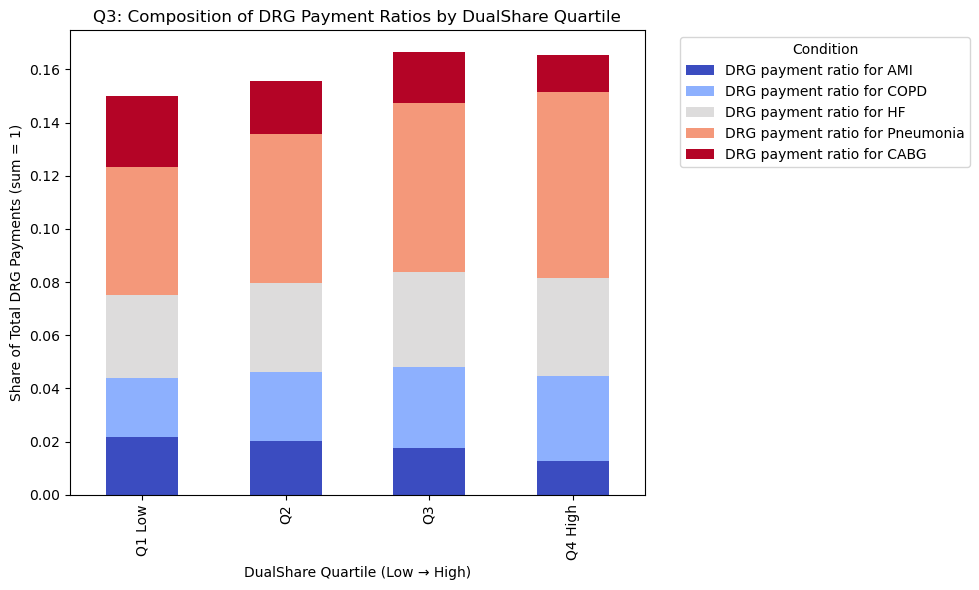

In [14]:
# ==============================================================
# VISUALIZATION: Composition of DRG Payment Ratios by DualShare Quartile
# --------------------------------------------------------------
# Stacked bar chart showing average share of each condition in total DRG payments.
# ==============================================================

drg_cols = [f"DRG payment ratio for {c}" for c in conditions if f"DRG payment ratio for {c}" in df_eda.columns]
df_drg = df_eda.groupby("DualShare_quartile")[drg_cols].mean()

df_drg.plot(kind="bar", stacked=True, figsize=(10,6), colormap="coolwarm")
plt.title("Q3: Composition of DRG Payment Ratios by DualShare Quartile")
plt.ylabel("Share of Total DRG Payments (sum = 1)")
plt.xlabel("DualShare Quartile (Low → High)")
plt.legend(title="Condition", bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()


In [15]:
# ==============================================================
# STEP 13.  SETUP FOR REDUCED-FORM REGRESSIONS
# --------------------------------------------------------------
# We use statsmodels for OLS estimation.
# ==============================================================

import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", context="talk")


                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.9934      0.000   4149.207      0.000       0.993       0.994
DualShare      0.0033      0.001      3.884      0.000       0.002       0.005


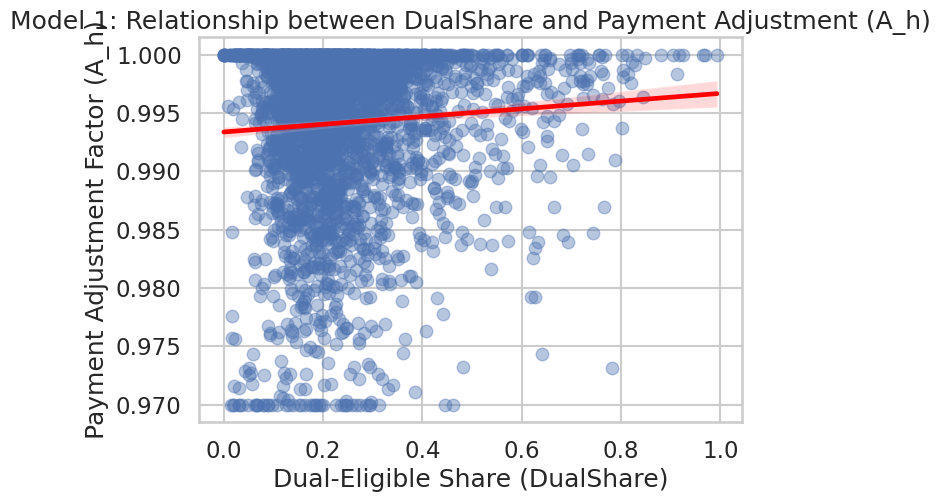

In [16]:
# ==============================================================
# MODEL 1: Relationship between Payment Adjustment (A_h)
#           and Dual-Eligible Proportion (DualShare)
# --------------------------------------------------------------
# Intuition: Are hospitals serving poorer populations more likely
# to face larger payment cuts under HRRP?
# ==============================================================

model1 = smf.ols("A_h ~ DualShare", data=df_eda).fit()
print(model1.summary().tables[1])

# Visualization: Scatter + fitted regression line
plt.figure(figsize=(7,5))
sns.regplot(x="DualShare", y="A_h", data=df_eda, scatter_kws={"alpha":0.4}, line_kws={"color":"red"})
plt.title("Model 1: Relationship between DualShare and Payment Adjustment (A_h)")
plt.xlabel("Dual-Eligible Share (DualShare)")
plt.ylabel("Payment Adjustment Factor (A_h)")
plt.show()


=== Effect of Dual-Eligible Share on ERR Deviation from Peer Median, by Condition ===


,Condition,Beta (DualShare),Std. Err.,p-value,R²,N,CI95 low,CI95 high
0,THA/TKA,0.0552,0.0189,0.0036,0.0030,2808,0.0181,0.0922
1,HF,0.0404,0.0097,0.0000,0.0058,3025,0.0215,0.0593
2,AMI,0.0299,0.0073,0.0000,0.0057,2928,0.0156,0.0442
3,Pneumonia,0.0274,0.0103,0.0078,0.0023,3052,0.0072,0.0475
4,COPD,0.0147,0.0079,0.0619,0.0011,3041,-0.0007,0.0301
5,CABG,-0.0176,0.0245,0.4724,0.0004,1154,-0.0656,0.0304


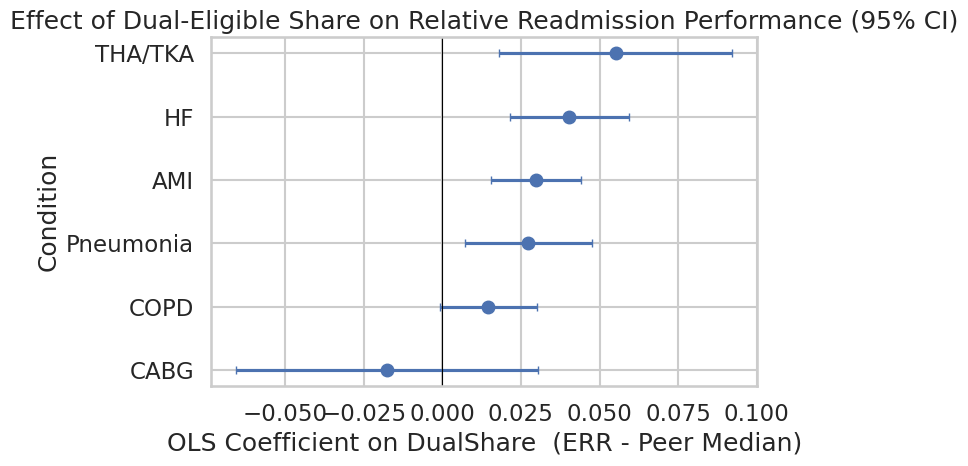


=== Deviation of ERR from Peer Median by Hospital (preview) ===


,Hospital CCN,Δ ERR (AMI),Δ ERR (COPD),Δ ERR (HF),Δ ERR (Pneumonia),Δ ERR (CABG),Δ ERR (THA/TKA)
0,010001,-0.008879,-0.002040,-0.035708,0.107262,0.055262,0.109444
1,010005,-0.026854,-0.118657,0.112681,-0.059108,NaN,0.320094
2,010006,0.046044,0.000895,0.022804,0.066479,0.107327,0.197606
3,010007,-0.012582,0.000134,0.008100,0.016932,NaN,0.184586
4,010008,0.011868,-0.042609,0.017257,-0.052196,NaN,NaN
5,010011,-0.006943,-0.016200,0.008726,0.022299,-0.017284,0.135517
6,010012,-0.053919,0.043800,0.111008,0.087033,NaN,0.056344
7,010016,0.048139,-0.040945,0.017219,-0.081852,0.076420,0.045816
8,010019,0.040460,0.073194,0.060143,0.082197,NaN,-0.073071
9,010021,0.002563,-0.068186,-0.020641,-0.054027,NaN,0.104542


In [17]:
# ==============================================================
# COMBINED (robust): Deviation regressions + table + 95% CI plot + preview
# Handles THA/TKA safely by renaming and quotes LHS in formulas.
# ==============================================================

import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

# 0) Conditions and safe column rename for THA/TKA
conditions = ["AMI", "COPD", "HF", "Pneumonia", "CABG", "THA/TKA"]

# If THA/TKA exists, also create a safe alias without the slash
if "ERR for THA/TKA" in df_eda.columns:
    df_eda = df_eda.rename(columns={"ERR for THA/TKA": "ERR for THA_TKA"})
if "Peer group median ERR for THA/TKA" in df_eda.columns:
    df_eda = df_eda.rename(columns={"Peer group median ERR for THA/TKA": "Peer group median ERR for THA_TKA"})

# Replace the label in the list for internal processing
conditions_clean = ["THA_TKA" if c == "THA/TKA" else c for c in conditions]

# 1) Create deviation columns (ERR - peer median) for each condition
for c in conditions_clean:
    err_col = f"ERR for {c}"
    med_col = f"Peer group median ERR for {c}"
    diff_col = f"ERR_diff_{c}"
    if (err_col in df_eda.columns) and (med_col in df_eda.columns):
        if diff_col not in df_eda.columns:
            df_eda[diff_col] = df_eda[err_col] - df_eda[med_col]

# 2) Run regressions: ERR_diff_c ~ DualShare (quote LHS with Q(...))
rows = []
for c in conditions_clean:
    var = f"ERR_diff_{c}"
    if var in df_eda.columns:
        m = smf.ols(f"Q('{var}') ~ DualShare", data=df_eda).fit()
        beta = m.params.get("DualShare", np.nan)
        se   = m.bse.get("DualShare", np.nan)
        pval = m.pvalues.get("DualShare", np.nan)
        rows.append({
            "Condition": c.replace("_", "/"),  # pretty label for THA/TKA
            "Beta (DualShare)": beta,
            "Std. Err.": se,
            "p-value": pval,
            "R²": m.rsquared,
            "N": int(m.nobs),
            "CI95 low": beta - 1.96*se if pd.notna(beta) and pd.notna(se) else np.nan,
            "CI95 high": beta + 1.96*se if pd.notna(beta) and pd.notna(se) else np.nan
        })

results_df = pd.DataFrame(rows)

# 3) Display tidy results
print("=== Effect of Dual-Eligible Share on ERR Deviation from Peer Median, by Condition ===")
display(
    results_df
      .sort_values(by="Beta (DualShare)", ascending=False)
      .reset_index(drop=True)
      .round({"Beta (DualShare)": 4, "Std. Err.": 4, "p-value": 4, "R²": 4, "CI95 low": 4, "CI95 high": 4})
)

# 4) Plot coefficients with 95% CIs
plot_df = results_df.dropna(subset=["Beta (DualShare)", "Std. Err."]).copy()
plot_df = plot_df.sort_values("Beta (DualShare)", ascending=True)

plt.figure(figsize=(8,5))
ypos = np.arange(len(plot_df))
plt.errorbar(
    x=plot_df["Beta (DualShare)"],
    y=ypos,
    xerr=1.96*plot_df["Std. Err."],
    fmt='o',
    capsize=3,
)
plt.axvline(0, color="black", linewidth=0.8)
plt.yticks(ypos, plot_df["Condition"])
plt.xlabel("OLS Coefficient on DualShare  (ERR - Peer Median)")
plt.ylabel("Condition")
plt.title("Effect of Dual-Eligible Share on Relative Readmission Performance (95% CI)")
plt.tight_layout()
plt.show()

# 5) Preview: deviations by hospital (top 10)
dev_cols = [c for c in df_eda.columns if c.startswith("ERR_diff_")]
preview = df_eda[["Hospital CCN"] + dev_cols].head(10).copy()
# prettify headers
pretty_map = {c: c.replace("ERR_diff_", "Δ ERR (").replace("_", "/") + ")" for c in dev_cols}
preview = preview.rename(columns=pretty_map)
print("\n=== Deviation of ERR from Peer Median by Hospital (preview) ===")
display(preview)
